# Training a model

Below is the example for a Gaussian Process regression using GpyTorch :class:`.ExactGaussianProcessRegressor`

This example shows how to use a GridInterpolationKernel module. This regression module is designed for when the function you're modeling has 2-3 dimensional inputs and you don't believe that the output can be additively decomposed.

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from gpwrapper import ExactGaussianProcessRegressor

%matplotlib inline

In [2]:
# We make an nxn grid of training points spaced every 1/(n-1) on [0,1]x[0,1]
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x)
# True function is sin( 2*pi*(x0+x1))
train_y = Variable(torch.sin(((train_x.data[:, 0] + train_x.data[:, 1]) * (2 * math.pi))))

In [7]:
# Step 1: Define the GP Model
# We use KISS-GP (kernel interpolation for scalable structured Gaussian Processes)
# as in https://arxiv.org/pdf/1503.01057.pdf
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        # Near-zero mean
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # GridInterpolationKernel over an ExactGP
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=30,
                                                    grid_bounds=[(0, 1), (0, 1)])
        # Register the log lengthscale as a trainable parametre
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

In [4]:
# Step 2: Wrap the model into our GP Wrapper
GP = ExactGaussianProcessRegressor(
    module = GPRegressionModel,
    train_split = None,
    max_epochs = 30,
)

# Step 3: Find optimal model hyperparameters
GP.fit(X=train_x, y=train_y)

# Step 4: Prediction
# Generate nxn grid of test points spaced on a grid of size 1/(n-1) in [0,1]x[0,1]
n = 10
test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)
        
observed_pred = GP.predict_proba(X=test_x)

  epoch    train_loss     dur
-------  ------------  ------
      1       14.8341  0.7840
      2       13.5055  0.6497
      3       11.2577  0.6526
      4        7.9356  0.6392
      5        4.3152  0.6376
      6        1.5715  0.6191
      7        0.0487  0.9330
      8       -0.7008  0.9250
      9       -1.0861  0.6500
     10       -1.3034  0.6215
     11       -1.4046  0.8344
     12       -1.4573  0.8155
     13       -1.4619  1.4072
     14       -1.4652  0.7618
     15       -1.4536  0.6928
     16       -1.4308  0.8905
     17       -1.4295  0.6811
     18       -1.3944  0.6641
     19       -1.4005  0.7505
     20       -1.3688  0.8708
     21       -1.3470  0.8153
     22       -1.3411  0.9305
     23       -1.3255  0.7480
     24       -1.2953  0.7673
     25       -1.2986  0.6975
     26       -1.2855  1.0879
     27       -1.2810  1.3208
     28       -1.2828  1.1667
     29       -1.2894  0.9203
     30       -1.2480  0.8368


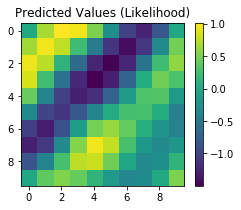

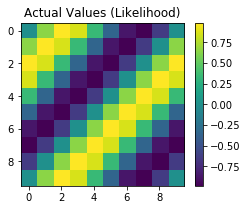

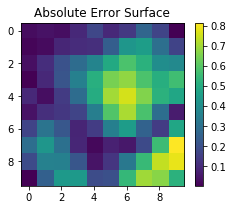

In [8]:
# Labels are predictive means
pred_labels = observed_pred.mean().view(n, n).data.numpy()

# Compute actual data from true function
test_y_actual = torch.sin(((test_x.data[:, 0] + test_x.data[:, 1]) * (2 * math.pi))).numpy().reshape(n, n)
# Calc abosolute error
delta_y = numpy.absolute(pred_labels - test_y_actual)

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')

# Using Sklearn Pipeline
Same as skorch, our wrapper provides an sklearn-compatible interface, so it is possible to put it into an sklearn Pipeline. An example is shown below:

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

GP = ExactGaussianProcessRegressor(
    module = GPRegressionModel,
    train_split = None,
    max_epochs = 30,
)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('GP', GP),
])

pipe.fit(X=train_x, y=train_y) # modify grid bound to (-2,2) to get it work

  epoch    train_loss     dur
-------  ------------  ------
      1       -1.4721  0.5799
      2       -1.5182  0.6935
      3       -1.5596  0.5339
      4       -1.6095  0.4730
      5       -1.6424  0.6032
      6       -1.6879  0.4327
      7       -1.7532  0.5686
      8       -1.7927  0.4427
      9       -1.8546  0.4587
     10       -1.8890  0.4202
     11       -1.9365  0.4170
     12       -1.9888  0.4198
     13       -2.0211  0.4233
     14       -2.0656  0.4227
     15       -2.1098  0.6163
     16       -2.1583  0.7492
     17       -2.1868  0.7747
     18       -2.2565  0.5601
     19       -2.2796  0.4750
     20       -2.3356  0.7395
     21       -2.3725  0.8041
     22       -2.3963  0.6248
     23       -2.4195  0.4389
     24       -2.4510  0.4295
     25       -2.5132  0.4303
     26       -2.5278  0.4273
     27       -2.6003  0.4407
     28       -2.6122  0.4560
     29       -2.6591  0.4402
     30       -2.6635  0.4431


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GP', <class 'gpwrapper.ExactGaussianProcessRegressor'>[initialized](
  module_=GPRegressionModel(
    (likelihood): GaussianLikelihood()
    (mean_module): ConstantMean()
    (base_covar_module): RBFKernel()
    (covar_module): GridInterpolationKernel(
      (base_kernel_module): RBFKernel()
    )
  ),
))])

# Grid search
Same as skorch, another advantage of our wrapper is that you can perform an sklearn GridSearchCV or RandomizedSearchCV in Gpytorch to find optimal hyperparameters. Here is an example:

In [6]:
from sklearn.model_selection import GridSearchCV

GP = ExactGaussianProcessRegressor(
    module = GPRegressionModel,
    train_split = None,
    max_epochs = 30,
)

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}
gs = GridSearchCV(GP, params, refit=False, cv=3, scoring='r2',
                 return_train_score=False)  # Use a different scoring function maybe?

gs.fit(X=train_x, y=train_y)
print('\n gs.best_score_ = {}, gs.best_params = {}'.format(gs.best_score_, gs.best_params_))

  epoch    train_loss     dur
-------  ------------  ------
      1       11.9679  0.4929
      2       11.7281  0.6773
      3       11.4784  0.5923
      4       11.2238  0.5399
      5       10.9599  0.5852
      6       10.6931  0.4637
      7       10.4084  0.4425
      8       10.1236  0.4594
      9        9.8259  0.4429
     10        9.5262  0.4819
  epoch    train_loss     dur
-------  ------------  ------
      1       12.2876  0.4378
      2       12.1936  0.5106
      3       12.0972  0.4403
      4       12.0011  0.4292
      5       11.9008  0.4393
      6       11.7997  0.4352
      7       11.6988  0.4331
      8       11.5884  0.4296
      9       11.4709  0.4293
     10       11.3525  0.4576
  epoch    train_loss     dur
-------  ------------  ------
      1       11.8738  0.4526
      2       11.6394  0.4514
      3       11.3966  0.4327
      4       11.1484  0.4478
      5       10.8856  0.4464
      6       10.6207  0.4593
      7       10.3471  0.4415
      8   

### Note:
Need to comment out **line 157 - 161** of `.../anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/__init__.py`
```
if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
                           indices.dtype.kind == 'i'):
    # This is often substantially faster than X[indices]
    return X.take(indices, axis=0)
else:
```
Otherwise an error would occur saying
`argument 'index' (position 1) must be Tensor, not numpy.ndarray`